In [1]:

import os
import matplotlib
import utilities as util

import read_pv as rpv
import pacemaking as pace
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
file= '.\EZT\APs'
df = rpv.import_folder(file)['voltage recording']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 300000 entries, ('sweep001', 0) to ('sweep001', 299999)
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   time       300000 non-null  float64
 1   primary    300000 non-null  float64
 2   secondary  300000 non-null  float64
dtypes: float64(3)
memory usage: 8.3+ MB
None


(0, 1.2)

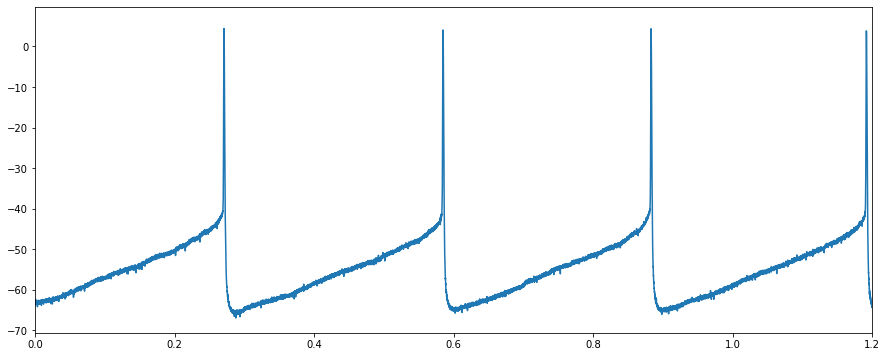

In [3]:
plt.figure(figsize=(15,6))
plt.plot(df.time, df.primary)
#plt.plot(df.time, df.secondary)
plt.xlim(0, 1.2)

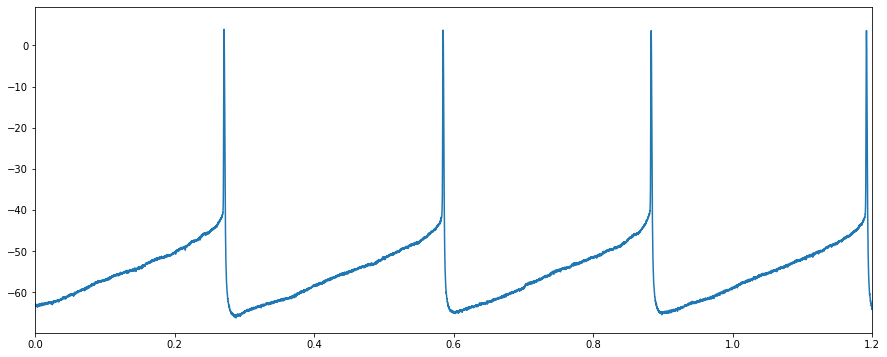

In [4]:
primsmth = util.simple_smoothing(df.primary, 3)
plt.figure(figsize=(15,6))
plt.plot(df.time, primsmth)
plt.xlim(0, 1.2)
#add in the smoothed primary column to the dataframe
df['smoothed']=primsmth


In [5]:
# calculating distcrete difference on the primary (mV) data with time (ms)
# values start with the second index and run till the end of the file
newarr = (df.smoothed[1:].values - df.smoothed[:-1].values) / (df.time[1:].values - df.time[:-1].values) / 1000
print(newarr.size)
#print(newarr)
#need to add an initial zero derivative value to make the array parameter lengths match the df data
dvdt = np.insert(newarr, [0], 0.0)
print(dvdt.size)
#print(dvdt)
df['derivative']=dvdt
print(df.head(5))

299999
300000
                  time    primary  secondary   smoothed  derivative
sweep    index                                                     
sweep001 0      0.0000 -63.598633 -15.869141        NaN    0.000000
         1      0.0001 -63.781738  -5.493164        NaN         NaN
         2      0.0002 -63.110352  -4.272461 -63.496908         NaN
         3      0.0003 -63.201904  -5.493164 -63.364665    1.322428
         4      0.0004 -63.293457  -3.662109 -63.201904    1.627604


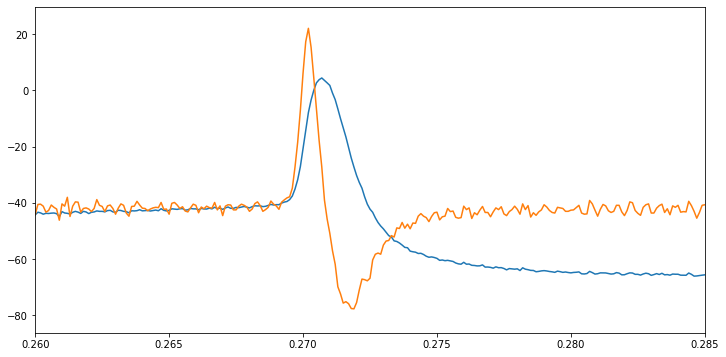

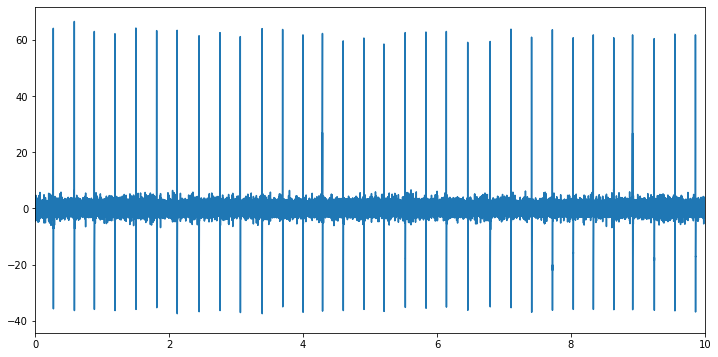

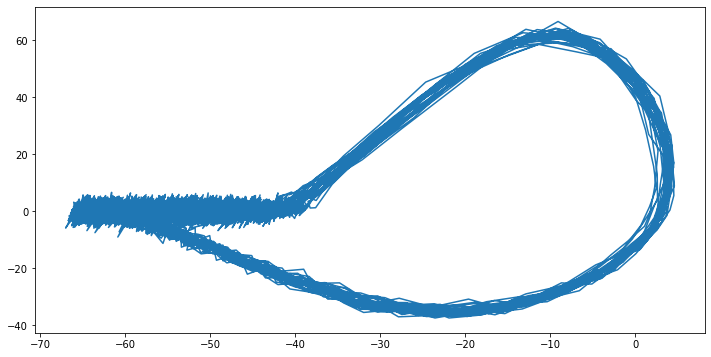

In [6]:

#plotting cell
#shifting the minimum voltage to overlay the derivative and the AP voltage trace
sftarr = dvdt - 42
#plotting out the derivative and voltage with time (use xlim values to restrict time window)
plt.figure(figsize=(12,6))
plt.plot(df.time, df.primary)
plt.plot(df.time, sftarr)
plt.xlim(0.26, 0.285)

#plotting out the discrete derivative with time (use xlim values to restrict time window)
plt.figure(figsize=(12,6))
plt.plot(df.time, df.derivative)
plt.xlim(0, 10)

#plotting out the phase plot of derivative with voltage (selected time window trace plotted)
#easy to see the AP voltage threshold (-40mV) and derivative threshold value (~6mV/ms)

APmask = (df.time > 0) & (df.time < 10)
APsubset = df[APmask].droplevel(0)
plt.figure(figsize=(12,6))
plt.plot(APsubset.primary, APsubset.derivative)
#plt.plot(df.primary, df.derivative)



In [7]:
ret_vals = []
indices=[]
mph=0
mpd=100
valley=False
hz=False
ret_indices=False
ret_times=False
times=[]

if valley:
    indices = pace.detect_peaks(df['primary'].values, mph=abs(mph), valley=valley, mpd=mpd)
else:
    indices = pace.detect_peaks(df['primary'].values, mph=mph, mpd=mpd)


#times = df.loc[indices, 'time'].values
#test=df.loc[indices, 'time'].values
#print(test[0:12])
#times_dif = times[1 : ] - times[ : -1]
times_dif = indices[1 : ] - indices[ : -1]
#providing a discrete time difference, index 1 - index 0, run to end - (end-1)
if hz:
    ret_vals.append(1000 / times_dif)
else:
    ret_vals.append(times_dif)
if ret_indices:
    ret_vals.append(indices)
if ret_times:
    ret_vals.append(times[1 : ])
#intervals = ret_vals[0] if len(ret_vals) == 1 else ret_vals
print('AP indices' , indices[:10])
stamping = indices[1:]/10
intervals = times_dif/10
freqs = 10000/times_dif

print('time diff' , times_dif[:9])
print(len(stamping))
#print(len(times_dif))
#print('return values' , ret_vals[0][:10])

timing = pd.DataFrame({'AP peak (ms)':stamping,'ISI (ms)': intervals, 'freq (Hz)': freqs})

#np.savetxt('intervals.csv', intervals)
#np.std(intervals)
#np.savetext('both.csv', both)
timing.to_csv(file +'timdel.csv', index= False)

AP indices [ 2707  5847  8830 11917 15045 18146 21203 24476 27602 30634]
time diff [3140 2983 3087 3128 3101 3057 3273 3126 3032]
95


96 APs
[  270.6   584.6   882.9  1191.6  1504.4  1814.5  2120.2  2447.5  2760.1
  3063.3  3389.2  3695.8  3999.4  4290.4  4600.1  4909.3  5208.6  5526.4
  5836.2  6140.2  6459.7  6794.7  7105.9  7413.6  7723.8  8035.   8335.
  8640.7  8921.9  9245.   9552.8  9860.9 10164.6 10487.9 10794.4 11092.
 11397.  11693.1 12003.8 12314.7 12624.1 12945.3 13244.2 13536.8 13850.1
 14158.1 14466.4 14782.4 15081.1 15388.6 15682.4 15979.  16283.1 16585.5
 16909.6 17223.5 17524.7 17827.2 18145.2 18460.6 18781.1 19105.  19432.1
 19748.5 20068.4 20394.3 20716.8 21031.  21341.5 21647.9 21950.2 22264.3
 22577.5 22889.7 23209.9 23539.  23857.1 24185.9 24510.9 24831.5 25145.6
 25442.8 25768.3 26092.4 26418.7 26730.2 27047.8 27358.6 27659.3 27961.6
 28265.8 28563.6 28876.5 29207.7 29520.1 29799.4]


(0, 2)

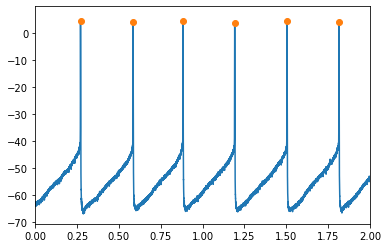

In [8]:
mask = (df.time > 0) & (df.time < 30)
subset = df[mask].droplevel(0)
plt.plot(subset.time, subset.primary)

peaks = pace.detect_peaks(subset.primary, mph=0, mpd=100)
print(len(peaks), 'APs')
print(peaks/10)
plt.plot(subset.time.iloc[peaks], subset.primary.iloc[peaks], 'o')
plt.xlim(0, 2)

In [23]:
csv= glob(file + '/*_VoltageRecording_*.csv')
csv

['/Users/ezt309/Desktop/data 2020/2020_perceval_ephys/1_23_20/BrightnessOverTime-01232020-1506_s1c1-003/BrightnessOverTime-01232020-1506_s1c1-003_Cycle00001_VoltageRecording_001.csv']